In [1]:
!pip install terratorch==0.99.7

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.1/845.1 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 62.3 MB/s eta 0:00:00
   

In [3]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from huggingface_hub import snapshot_download

wxc_downscaling not installed
wxc_downscaling not installed


In [4]:
import sys
import os

if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('Landslide4sense.zip'):
    gdown.download("https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z")
    !unzip Landslide4sense.zip
  local_path = '.'
else:
  local_path = snapshot_download(repo_id='ibm-nasa-geospatial/Landslide4sense', repo_type="dataset", cache_dir='.')

In [5]:
local_path

'.'

# Landslide4Sense Example

In [6]:
DATASET_PATH = local_path #os.path.join('dataset_dir', 'Landslide4sense')

In [7]:
# those are the recommended transforms for this task
transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Flip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

In [8]:
# this datamodule allows access to the dataset in its various splits.
datamodule = Landslide4SenseNonGeoDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [9]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([-0.4914,
  -0.3074,
  -0.1277,
  -0.0625,
  0.0439,
  0.0803,
  0.0644,
  0.0802,
  0.3,
  0.4082,
  0.0823,
  0.0516,
  0.3338,
  0.7819],
 [0.9325,
  0.8775,
  0.886,
  0.8869,
  0.8857,
  0.8418,
  0.8354,
  0.8491,
  0.9061,
  1.6072,
  0.8848,
  0.9232,
  0.9018,
  1.2913])

In [10]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3799

In [11]:
# checking datasets available bands
train_dataset.all_band_names

('COASTAL AEROSOL',
 'BLUE',
 'GREEN',
 'RED',
 'RED_EDGE_1',
 'RED_EDGE_2',
 'RED_EDGE_3',
 'NIR_BROAD',
 'WATER_VAPOR',
 'CIRRUS',
 'SWIR_1',
 'SWIR_2',
 'SLOPE',
 'DEM')

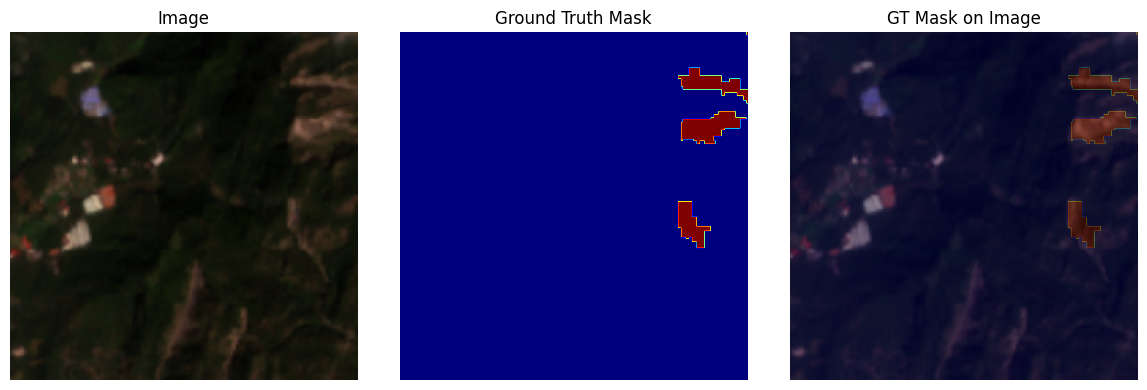

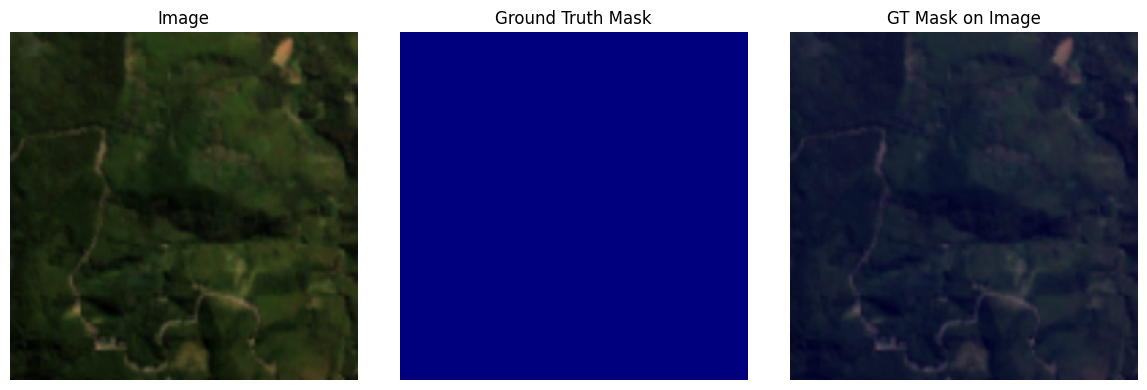

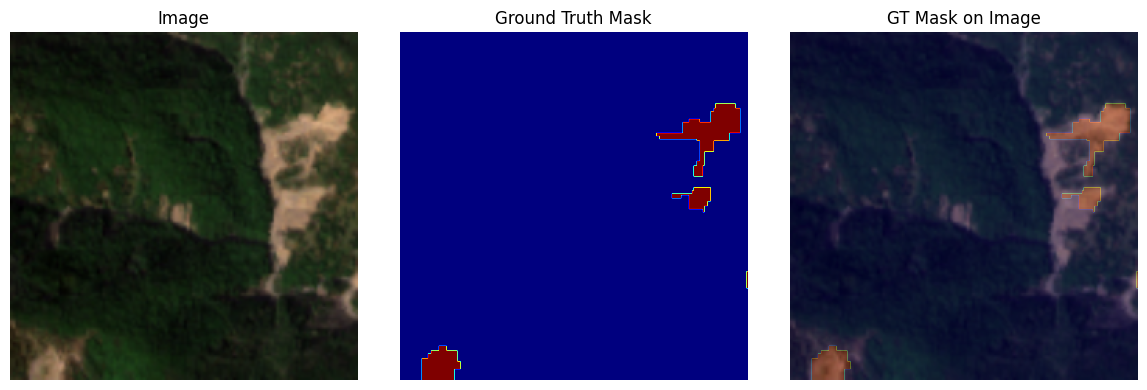

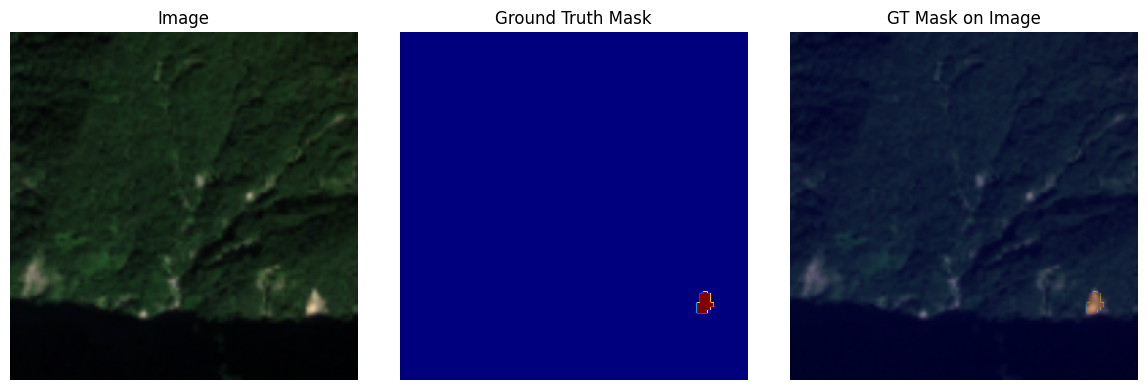

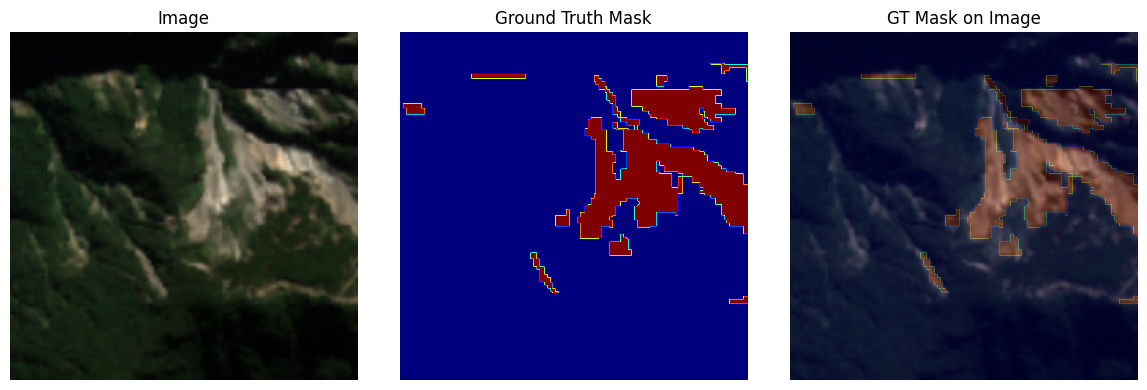

In [12]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [13]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

245

In [14]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

800

In [15]:
pl.seed_everything(0)

# Logger
logger = TensorBoardLogger(
    save_dir="landslide4sense",
    name="tutorial"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# colab will kill the kernel after ~24 epochs, therefore stopping after two and pull the correct checkpoint after
max_epochs = 1 if 'google.colab' in sys.modules else 50


checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",      # Directory to save the checkpoints
    filename="epoch-{epoch:02d}", # Filename format
    save_top_k=-1,               # Save all checkpoints
    every_n_epochs=50,            # Save every epoch
    save_on_train_epoch_end=True # Ensure saving after each epoch
)


# Trainer
trainer = pl.Trainer(
    accelerator=device,
    num_nodes=1,
    logger = logger,
    max_epochs=max_epochs,
    check_val_every_n_epoch=2,
    log_every_n_steps=50,
    enable_checkpointing=True,
    default_root_dir="root_dir",
    callbacks=[checkpoint_callback],
)

# DataModule
data_module = Landslide4SenseNonGeoDataModule(
    batch_size=8,
    bands = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    lr=1.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-p

In [16]:
trainer.fit(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 319 M  | train
1 | criterion     | FocalLoss        | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | ModuleList       | 0      | train
-----------------------------------------------------------
319 M     Trainable params
0         Non-trainable params
319 M     Total params
1,277.348 Total estimated model params size (MB)
627       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 319 M  | train
1 | crite

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [20]:
if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('landslide4sense.ckpt.zip'):
    gdown.download("https://drive.google.com/uc?id=12lFg4N2ibc4g6Pz8CiX5cJQNTuUXcTmF")
    !unzip landslide4sense.ckpt.zip

In [21]:
trainer.test(model, datamodule=data_module, ckpt_path="./landslide4sense.ckpt")

INFO: Restoring states from the checkpoint path at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./landslide4sense.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./landslide4sense.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.9852952361106873          │
│      test/Multiclass_F1_Score       │         0.9852951765060425          │
│    test/Multiclass_Jaccard_Index    │         0.6587659120559692          │
│ test/Multiclass_Jaccard_Index_Micro │         0.9710166454315186          │
│              test/loss              │       1.8921706441688002e-06        │
│      test/multiclassaccuracy_0      │         0.9967918395996094          │
│      test/multiclassaccuracy_1      │         0.3877629339694977          │
│    test/multiclassjaccardindex_0    │          0.985186755657196          │
│    test/multiclassjaccardindex_1    │         0.3323451280593872          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 1.8921706441688002e-06,
  'test/Multiclass_Accuracy': 0.9852952361106873,
  'test/multiclassaccuracy_0': 0.9967918395996094,
  'test/multiclassaccuracy_1': 0.3877629339694977,
  'test/Multiclass_F1_Score': 0.9852951765060425,
  'test/Multiclass_Jaccard_Index': 0.6587659120559692,
  'test/multiclassjaccardindex_0': 0.985186755657196,
  'test/multiclassjaccardindex_1': 0.3323451280593872,
  'test/Multiclass_Jaccard_Index_Micro': 0.9710166454315186}]

In [15]:
trainer.predict(model, datamodule=data_module, ckpt_path="./landslide4sense.ckpt")

INFO: Restoring states from the checkpoint path at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./landslide4sense.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./landslide4sense.ckpt


MisconfigurationException: Landslide4SenseNonGeoDataModule.setup must define one of ('predict_dataset', 'dataset').

In [16]:
checkpoint = torch.load("./landslide4sense.ckpt", map_location=torch.device("cuda"))

state_dict = checkpoint["state_dict"]
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("encoder."):
        new_key = f"model.{key}"
    elif key.startswith("model."):
        new_key = key.replace("model.", "")
    else:
        new_key = key
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)
model.eval()

<ipython-input-16-4328287ff4d9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./landslide4sense.ckpt", map_location=torch.device("cuda"))


RuntimeError: Error(s) in loading state_dict for SemanticSegmentationTask:
	Missing key(s) in state_dict: "model.encoder._timm_module.cls_token", "model.encoder._timm_module.pos_embed", "model.encoder._timm_module.patch_embed.proj.weight", "model.encoder._timm_module.patch_embed.proj.bias", "model.encoder._timm_module.blocks.0.norm1.weight", "model.encoder._timm_module.blocks.0.norm1.bias", "model.encoder._timm_module.blocks.0.attn.qkv.weight", "model.encoder._timm_module.blocks.0.attn.qkv.bias", "model.encoder._timm_module.blocks.0.attn.proj.weight", "model.encoder._timm_module.blocks.0.attn.proj.bias", "model.encoder._timm_module.blocks.0.norm2.weight", "model.encoder._timm_module.blocks.0.norm2.bias", "model.encoder._timm_module.blocks.0.mlp.fc1.weight", "model.encoder._timm_module.blocks.0.mlp.fc1.bias", "model.encoder._timm_module.blocks.0.mlp.fc2.weight", "model.encoder._timm_module.blocks.0.mlp.fc2.bias", "model.encoder._timm_module.blocks.1.norm1.weight", "model.encoder._timm_module.blocks.1.norm1.bias", "model.encoder._timm_module.blocks.1.attn.qkv.weight", "model.encoder._timm_module.blocks.1.attn.qkv.bias", "model.encoder._timm_module.blocks.1.attn.proj.weight", "model.encoder._timm_module.blocks.1.attn.proj.bias", "model.encoder._timm_module.blocks.1.norm2.weight", "model.encoder._timm_module.blocks.1.norm2.bias", "model.encoder._timm_module.blocks.1.mlp.fc1.weight", "model.encoder._timm_module.blocks.1.mlp.fc1.bias", "model.encoder._timm_module.blocks.1.mlp.fc2.weight", "model.encoder._timm_module.blocks.1.mlp.fc2.bias", "model.encoder._timm_module.blocks.2.norm1.weight", "model.encoder._timm_module.blocks.2.norm1.bias", "model.encoder._timm_module.blocks.2.attn.qkv.weight", "model.encoder._timm_module.blocks.2.attn.qkv.bias", "model.encoder._timm_module.blocks.2.attn.proj.weight", "model.encoder._timm_module.blocks.2.attn.proj.bias", "model.encoder._timm_module.blocks.2.norm2.weight", "model.encoder._timm_module.blocks.2.norm2.bias", "model.encoder._timm_module.blocks.2.mlp.fc1.weight", "model.encoder._timm_module.blocks.2.mlp.fc1.bias", "model.encoder._timm_module.blocks.2.mlp.fc2.weight", "model.encoder._timm_module.blocks.2.mlp.fc2.bias", "model.encoder._timm_module.blocks.3.norm1.weight", "model.encoder._timm_module.blocks.3.norm1.bias", "model.encoder._timm_module.blocks.3.attn.qkv.weight", "model.encoder._timm_module.blocks.3.attn.qkv.bias", "model.encoder._timm_module.blocks.3.attn.proj.weight", "model.encoder._timm_module.blocks.3.attn.proj.bias", "model.encoder._timm_module.blocks.3.norm2.weight", "model.encoder._timm_module.blocks.3.norm2.bias", "model.encoder._timm_module.blocks.3.mlp.fc1.weight", "model.encoder._timm_module.blocks.3.mlp.fc1.bias", "model.encoder._timm_module.blocks.3.mlp.fc2.weight", "model.encoder._timm_module.blocks.3.mlp.fc2.bias", "model.encoder._timm_module.blocks.4.norm1.weight", "model.encoder._timm_module.blocks.4.norm1.bias", "model.encoder._timm_module.blocks.4.attn.qkv.weight", "model.encoder._timm_module.blocks.4.attn.qkv.bias", "model.encoder._timm_module.blocks.4.attn.proj.weight", "model.encoder._timm_module.blocks.4.attn.proj.bias", "model.encoder._timm_module.blocks.4.norm2.weight", "model.encoder._timm_module.blocks.4.norm2.bias", "model.encoder._timm_module.blocks.4.mlp.fc1.weight", "model.encoder._timm_module.blocks.4.mlp.fc1.bias", "model.encoder._timm_module.blocks.4.mlp.fc2.weight", "model.encoder._timm_module.blocks.4.mlp.fc2.bias", "model.encoder._timm_module.blocks.5.norm1.weight", "model.encoder._timm_module.blocks.5.norm1.bias", "model.encoder._timm_module.blocks.5.attn.qkv.weight", "model.encoder._timm_module.blocks.5.attn.qkv.bias", "model.encoder._timm_module.blocks.5.attn.proj.weight", "model.encoder._timm_module.blocks.5.attn.proj.bias", "model.encoder._timm_module.blocks.5.norm2.weight", "model.encoder._timm_module.blocks.5.norm2.bias", "model.encoder._timm_module.blocks.5.mlp.fc1.weight", "model.encoder._timm_module.blocks.5.mlp.fc1.bias", "model.encoder._timm_module.blocks.5.mlp.fc2.weight", "model.encoder._timm_module.blocks.5.mlp.fc2.bias", "model.encoder._timm_module.blocks.6.norm1.weight", "model.encoder._timm_module.blocks.6.norm1.bias", "model.encoder._timm_module.blocks.6.attn.qkv.weight", "model.encoder._timm_module.blocks.6.attn.qkv.bias", "model.encoder._timm_module.blocks.6.attn.proj.weight", "model.encoder._timm_module.blocks.6.attn.proj.bias", "model.encoder._timm_module.blocks.6.norm2.weight", "model.encoder._timm_module.blocks.6.norm2.bias", "model.encoder._timm_module.blocks.6.mlp.fc1.weight", "model.encoder._timm_module.blocks.6.mlp.fc1.bias", "model.encoder._timm_module.blocks.6.mlp.fc2.weight", "model.encoder._timm_module.blocks.6.mlp.fc2.bias", "model.encoder._timm_module.blocks.7.norm1.weight", "model.encoder._timm_module.blocks.7.norm1.bias", "model.encoder._timm_module.blocks.7.attn.qkv.weight", "model.encoder._timm_module.blocks.7.attn.qkv.bias", "model.encoder._timm_module.blocks.7.attn.proj.weight", "model.encoder._timm_module.blocks.7.attn.proj.bias", "model.encoder._timm_module.blocks.7.norm2.weight", "model.encoder._timm_module.blocks.7.norm2.bias", "model.encoder._timm_module.blocks.7.mlp.fc1.weight", "model.encoder._timm_module.blocks.7.mlp.fc1.bias", "model.encoder._timm_module.blocks.7.mlp.fc2.weight", "model.encoder._timm_module.blocks.7.mlp.fc2.bias", "model.encoder._timm_module.blocks.8.norm1.weight", "model.encoder._timm_module.blocks.8.norm1.bias", "model.encoder._timm_module.blocks.8.attn.qkv.weight", "model.encoder._timm_module.blocks.8.attn.qkv.bias", "model.encoder._timm_module.blocks.8.attn.proj.weight", "model.encoder._timm_module.blocks.8.attn.proj.bias", "model.encoder._timm_module.blocks.8.norm2.weight", "model.encoder._timm_module.blocks.8.norm2.bias", "model.encoder._timm_module.blocks.8.mlp.fc1.weight", "model.encoder._timm_module.blocks.8.mlp.fc1.bias", "model.encoder._timm_module.blocks.8.mlp.fc2.weight", "model.encoder._timm_module.blocks.8.mlp.fc2.bias", "model.encoder._timm_module.blocks.9.norm1.weight", "model.encoder._timm_module.blocks.9.norm1.bias", "model.encoder._timm_module.blocks.9.attn.qkv.weight", "model.encoder._timm_module.blocks.9.attn.qkv.bias", "model.encoder._timm_module.blocks.9.attn.proj.weight", "model.encoder._timm_module.blocks.9.attn.proj.bias", "model.encoder._timm_module.blocks.9.norm2.weight", "model.encoder._timm_module.blocks.9.norm2.bias", "model.encoder._timm_module.blocks.9.mlp.fc1.weight", "model.encoder._timm_module.blocks.9.mlp.fc1.bias", "model.encoder._timm_module.blocks.9.mlp.fc2.weight", "model.encoder._timm_module.blocks.9.mlp.fc2.bias", "model.encoder._timm_module.blocks.10.norm1.weight", "model.encoder._timm_module.blocks.10.norm1.bias", "model.encoder._timm_module.blocks.10.attn.qkv.weight", "model.encoder._timm_module.blocks.10.attn.qkv.bias", "model.encoder._timm_module.blocks.10.attn.proj.weight", "model.encoder._timm_module.blocks.10.attn.proj.bias", "model.encoder._timm_module.blocks.10.norm2.weight", "model.encoder._timm_module.blocks.10.norm2.bias", "model.encoder._timm_module.blocks.10.mlp.fc1.weight", "model.encoder._timm_module.blocks.10.mlp.fc1.bias", "model.encoder._timm_module.blocks.10.mlp.fc2.weight", "model.encoder._timm_module.blocks.10.mlp.fc2.bias", "model.encoder._timm_module.blocks.11.norm1.weight", "model.encoder._timm_module.blocks.11.norm1.bias", "model.encoder._timm_module.blocks.11.attn.qkv.weight", "model.encoder._timm_module.blocks.11.attn.qkv.bias", "model.encoder._timm_module.blocks.11.attn.proj.weight", "model.encoder._timm_module.blocks.11.attn.proj.bias", "model.encoder._timm_module.blocks.11.norm2.weight", "model.encoder._timm_module.blocks.11.norm2.bias", "model.encoder._timm_module.blocks.11.mlp.fc1.weight", "model.encoder._timm_module.blocks.11.mlp.fc1.bias", "model.encoder._timm_module.blocks.11.mlp.fc2.weight", "model.encoder._timm_module.blocks.11.mlp.fc2.bias", "model.encoder._timm_module.blocks.12.norm1.weight", "model.encoder._timm_module.blocks.12.norm1.bias", "model.encoder._timm_module.blocks.12.attn.qkv.weight", "model.encoder._timm_module.blocks.12.attn.qkv.bias", "model.encoder._timm_module.blocks.12.attn.proj.weight", "model.encoder._timm_module.blocks.12.attn.proj.bias", "model.encoder._timm_module.blocks.12.norm2.weight", "model.encoder._timm_module.blocks.12.norm2.bias", "model.encoder._timm_module.blocks.12.mlp.fc1.weight", "model.encoder._timm_module.blocks.12.mlp.fc1.bias", "model.encoder._timm_module.blocks.12.mlp.fc2.weight", "model.encoder._timm_module.blocks.12.mlp.fc2.bias", "model.encoder._timm_module.blocks.13.norm1.weight", "model.encoder._timm_module.blocks.13.norm1.bias", "model.encoder._timm_module.blocks.13.attn.qkv.weight", "model.encoder._timm_module.blocks.13.attn.qkv.bias", "model.encoder._timm_module.blocks.13.attn.proj.weight", "model.encoder._timm_module.blocks.13.attn.proj.bias", "model.encoder._timm_module.blocks.13.norm2.weight", "model.encoder._timm_module.blocks.13.norm2.bias", "model.encoder._timm_module.blocks.13.mlp.fc1.weight", "model.encoder._timm_module.blocks.13.mlp.fc1.bias", "model.encoder._timm_module.blocks.13.mlp.fc2.weight", "model.encoder._timm_module.blocks.13.mlp.fc2.bias", "model.encoder._timm_module.blocks.14.norm1.weight", "model.encoder._timm_module.blocks.14.norm1.bias", "model.encoder._timm_module.blocks.14.attn.qkv.weight", "model.encoder._timm_module.blocks.14.attn.qkv.bias", "model.encoder._timm_module.blocks.14.attn.proj.weight", "model.encoder._timm_module.blocks.14.attn.proj.bias", "model.encoder._timm_module.blocks.14.norm2.weight", "model.encoder._timm_module.blocks.14.norm2.bias", "model.encoder._timm_module.blocks.14.mlp.fc1.weight", "model.encoder._timm_module.blocks.14.mlp.fc1.bias", "model.encoder._timm_module.blocks.14.mlp.fc2.weight", "model.encoder._timm_module.blocks.14.mlp.fc2.bias", "model.encoder._timm_module.blocks.15.norm1.weight", "model.encoder._timm_module.blocks.15.norm1.bias", "model.encoder._timm_module.blocks.15.attn.qkv.weight", "model.encoder._timm_module.blocks.15.attn.qkv.bias", "model.encoder._timm_module.blocks.15.attn.proj.weight", "model.encoder._timm_module.blocks.15.attn.proj.bias", "model.encoder._timm_module.blocks.15.norm2.weight", "model.encoder._timm_module.blocks.15.norm2.bias", "model.encoder._timm_module.blocks.15.mlp.fc1.weight", "model.encoder._timm_module.blocks.15.mlp.fc1.bias", "model.encoder._timm_module.blocks.15.mlp.fc2.weight", "model.encoder._timm_module.blocks.15.mlp.fc2.bias", "model.encoder._timm_module.blocks.16.norm1.weight", "model.encoder._timm_module.blocks.16.norm1.bias", "model.encoder._timm_module.blocks.16.attn.qkv.weight", "model.encoder._timm_module.blocks.16.attn.qkv.bias", "model.encoder._timm_module.blocks.16.attn.proj.weight", "model.encoder._timm_module.blocks.16.attn.proj.bias", "model.encoder._timm_module.blocks.16.norm2.weight", "model.encoder._timm_module.blocks.16.norm2.bias", "model.encoder._timm_module.blocks.16.mlp.fc1.weight", "model.encoder._timm_module.blocks.16.mlp.fc1.bias", "model.encoder._timm_module.blocks.16.mlp.fc2.weight", "model.encoder._timm_module.blocks.16.mlp.fc2.bias", "model.encoder._timm_module.blocks.17.norm1.weight", "model.encoder._timm_module.blocks.17.norm1.bias", "model.encoder._timm_module.blocks.17.attn.qkv.weight", "model.encoder._timm_module.blocks.17.attn.qkv.bias", "model.encoder._timm_module.blocks.17.attn.proj.weight", "model.encoder._timm_module.blocks.17.attn.proj.bias", "model.encoder._timm_module.blocks.17.norm2.weight", "model.encoder._timm_module.blocks.17.norm2.bias", "model.encoder._timm_module.blocks.17.mlp.fc1.weight", "model.encoder._timm_module.blocks.17.mlp.fc1.bias", "model.encoder._timm_module.blocks.17.mlp.fc2.weight", "model.encoder._timm_module.blocks.17.mlp.fc2.bias", "model.encoder._timm_module.blocks.18.norm1.weight", "model.encoder._timm_module.blocks.18.norm1.bias", "model.encoder._timm_module.blocks.18.attn.qkv.weight", "model.encoder._timm_module.blocks.18.attn.qkv.bias", "model.encoder._timm_module.blocks.18.attn.proj.weight", "model.encoder._timm_module.blocks.18.attn.proj.bias", "model.encoder._timm_module.blocks.18.norm2.weight", "model.encoder._timm_module.blocks.18.norm2.bias", "model.encoder._timm_module.blocks.18.mlp.fc1.weight", "model.encoder._timm_module.blocks.18.mlp.fc1.bias", "model.encoder._timm_module.blocks.18.mlp.fc2.weight", "model.encoder._timm_module.blocks.18.mlp.fc2.bias", "model.encoder._timm_module.blocks.19.norm1.weight", "model.encoder._timm_module.blocks.19.norm1.bias", "model.encoder._timm_module.blocks.19.attn.qkv.weight", "model.encoder._timm_module.blocks.19.attn.qkv.bias", "model.encoder._timm_module.blocks.19.attn.proj.weight", "model.encoder._timm_module.blocks.19.attn.proj.bias", "model.encoder._timm_module.blocks.19.norm2.weight", "model.encoder._timm_module.blocks.19.norm2.bias", "model.encoder._timm_module.blocks.19.mlp.fc1.weight", "model.encoder._timm_module.blocks.19.mlp.fc1.bias", "model.encoder._timm_module.blocks.19.mlp.fc2.weight", "model.encoder._timm_module.blocks.19.mlp.fc2.bias", "model.encoder._timm_module.blocks.20.norm1.weight", "model.encoder._timm_module.blocks.20.norm1.bias", "model.encoder._timm_module.blocks.20.attn.qkv.weight", "model.encoder._timm_module.blocks.20.attn.qkv.bias", "model.encoder._timm_module.blocks.20.attn.proj.weight", "model.encoder._timm_module.blocks.20.attn.proj.bias", "model.encoder._timm_module.blocks.20.norm2.weight", "model.encoder._timm_module.blocks.20.norm2.bias", "model.encoder._timm_module.blocks.20.mlp.fc1.weight", "model.encoder._timm_module.blocks.20.mlp.fc1.bias", "model.encoder._timm_module.blocks.20.mlp.fc2.weight", "model.encoder._timm_module.blocks.20.mlp.fc2.bias", "model.encoder._timm_module.blocks.21.norm1.weight", "model.encoder._timm_module.blocks.21.norm1.bias", "model.encoder._timm_module.blocks.21.attn.qkv.weight", "model.encoder._timm_module.blocks.21.attn.qkv.bias", "model.encoder._timm_module.blocks.21.attn.proj.weight", "model.encoder._timm_module.blocks.21.attn.proj.bias", "model.encoder._timm_module.blocks.21.norm2.weight", "model.encoder._timm_module.blocks.21.norm2.bias", "model.encoder._timm_module.blocks.21.mlp.fc1.weight", "model.encoder._timm_module.blocks.21.mlp.fc1.bias", "model.encoder._timm_module.blocks.21.mlp.fc2.weight", "model.encoder._timm_module.blocks.21.mlp.fc2.bias", "model.encoder._timm_module.blocks.22.norm1.weight", "model.encoder._timm_module.blocks.22.norm1.bias", "model.encoder._timm_module.blocks.22.attn.qkv.weight", "model.encoder._timm_module.blocks.22.attn.qkv.bias", "model.encoder._timm_module.blocks.22.attn.proj.weight", "model.encoder._timm_module.blocks.22.attn.proj.bias", "model.encoder._timm_module.blocks.22.norm2.weight", "model.encoder._timm_module.blocks.22.norm2.bias", "model.encoder._timm_module.blocks.22.mlp.fc1.weight", "model.encoder._timm_module.blocks.22.mlp.fc1.bias", "model.encoder._timm_module.blocks.22.mlp.fc2.weight", "model.encoder._timm_module.blocks.22.mlp.fc2.bias", "model.encoder._timm_module.blocks.23.norm1.weight", "model.encoder._timm_module.blocks.23.norm1.bias", "model.encoder._timm_module.blocks.23.attn.qkv.weight", "model.encoder._timm_module.blocks.23.attn.qkv.bias", "model.encoder._timm_module.blocks.23.attn.proj.weight", "model.encoder._timm_module.blocks.23.attn.proj.bias", "model.encoder._timm_module.blocks.23.norm2.weight", "model.encoder._timm_module.blocks.23.norm2.bias", "model.encoder._timm_module.blocks.23.mlp.fc1.weight", "model.encoder._timm_module.blocks.23.mlp.fc1.bias", "model.encoder._timm_module.blocks.23.mlp.fc2.weight", "model.encoder._timm_module.blocks.23.mlp.fc2.bias", "model.encoder._timm_module.norm.weight", "model.encoder._timm_module.norm.bias", "model.decoder.fpn1.0.weight", "model.decoder.fpn1.0.bias", "model.decoder.fpn1.1.weight", "model.decoder.fpn1.1.bias", "model.decoder.fpn1.1.running_mean", "model.decoder.fpn1.1.running_var", "model.decoder.fpn1.3.weight", "model.decoder.fpn1.3.bias", "model.decoder.fpn2.0.weight", "model.decoder.fpn2.0.bias", "model.decoder.psp_modules.0.1.conv.weight", "model.decoder.psp_modules.0.1.norm.weight", "model.decoder.psp_modules.0.1.norm.bias", "model.decoder.psp_modules.0.1.norm.running_mean", "model.decoder.psp_modules.0.1.norm.running_var", "model.decoder.psp_modules.1.1.conv.weight", "model.decoder.psp_modules.1.1.norm.weight", "model.decoder.psp_modules.1.1.norm.bias", "model.decoder.psp_modules.1.1.norm.running_mean", "model.decoder.psp_modules.1.1.norm.running_var", "model.decoder.psp_modules.2.1.conv.weight", "model.decoder.psp_modules.2.1.norm.weight", "model.decoder.psp_modules.2.1.norm.bias", "model.decoder.psp_modules.2.1.norm.running_mean", "model.decoder.psp_modules.2.1.norm.running_var", "model.decoder.psp_modules.3.1.conv.weight", "model.decoder.psp_modules.3.1.norm.weight", "model.decoder.psp_modules.3.1.norm.bias", "model.decoder.psp_modules.3.1.norm.running_mean", "model.decoder.psp_modules.3.1.norm.running_var", "model.decoder.bottleneck.conv.weight", "model.decoder.bottleneck.norm.weight", "model.decoder.bottleneck.norm.bias", "model.decoder.bottleneck.norm.running_mean", "model.decoder.bottleneck.norm.running_var", "model.decoder.lateral_convs.0.conv.weight", "model.decoder.lateral_convs.0.norm.weight", "model.decoder.lateral_convs.0.norm.bias", "model.decoder.lateral_convs.0.norm.running_mean", "model.decoder.lateral_convs.0.norm.running_var", "model.decoder.lateral_convs.1.conv.weight", "model.decoder.lateral_convs.1.norm.weight", "model.decoder.lateral_convs.1.norm.bias", "model.decoder.lateral_convs.1.norm.running_mean", "model.decoder.lateral_convs.1.norm.running_var", "model.decoder.lateral_convs.2.conv.weight", "model.decoder.lateral_convs.2.norm.weight", "model.decoder.lateral_convs.2.norm.bias", "model.decoder.lateral_convs.2.norm.running_mean", "model.decoder.lateral_convs.2.norm.running_var", "model.decoder.fpn_convs.0.conv.weight", "model.decoder.fpn_convs.0.norm.weight", "model.decoder.fpn_convs.0.norm.bias", "model.decoder.fpn_convs.0.norm.running_mean", "model.decoder.fpn_convs.0.norm.running_var", "model.decoder.fpn_convs.1.conv.weight", "model.decoder.fpn_convs.1.norm.weight", "model.decoder.fpn_convs.1.norm.bias", "model.decoder.fpn_convs.1.norm.running_mean", "model.decoder.fpn_convs.1.norm.running_var", "model.decoder.fpn_convs.2.conv.weight", "model.decoder.fpn_convs.2.norm.weight", "model.decoder.fpn_convs.2.norm.bias", "model.decoder.fpn_convs.2.norm.running_mean", "model.decoder.fpn_convs.2.norm.running_var", "model.decoder.fpn_bottleneck.conv.weight", "model.decoder.fpn_bottleneck.norm.weight", "model.decoder.fpn_bottleneck.norm.bias", "model.decoder.fpn_bottleneck.norm.running_mean", "model.decoder.fpn_bottleneck.norm.running_var", "model.head.head.0.0.0.weight", "model.head.head.0.0.0.bias", "model.head.head.0.1.0.weight", "model.head.head.0.1.0.bias", "model.head.head.2.weight", "model.head.head.2.bias". 
	Unexpected key(s) in state_dict: "encoder._timm_module.cls_token", "encoder._timm_module.pos_embed", "encoder._timm_module.patch_embed.proj.weight", "encoder._timm_module.patch_embed.proj.bias", "encoder._timm_module.blocks.0.norm1.weight", "encoder._timm_module.blocks.0.norm1.bias", "encoder._timm_module.blocks.0.attn.qkv.weight", "encoder._timm_module.blocks.0.attn.qkv.bias", "encoder._timm_module.blocks.0.attn.proj.weight", "encoder._timm_module.blocks.0.attn.proj.bias", "encoder._timm_module.blocks.0.norm2.weight", "encoder._timm_module.blocks.0.norm2.bias", "encoder._timm_module.blocks.0.mlp.fc1.weight", "encoder._timm_module.blocks.0.mlp.fc1.bias", "encoder._timm_module.blocks.0.mlp.fc2.weight", "encoder._timm_module.blocks.0.mlp.fc2.bias", "encoder._timm_module.blocks.1.norm1.weight", "encoder._timm_module.blocks.1.norm1.bias", "encoder._timm_module.blocks.1.attn.qkv.weight", "encoder._timm_module.blocks.1.attn.qkv.bias", "encoder._timm_module.blocks.1.attn.proj.weight", "encoder._timm_module.blocks.1.attn.proj.bias", "encoder._timm_module.blocks.1.norm2.weight", "encoder._timm_module.blocks.1.norm2.bias", "encoder._timm_module.blocks.1.mlp.fc1.weight", "encoder._timm_module.blocks.1.mlp.fc1.bias", "encoder._timm_module.blocks.1.mlp.fc2.weight", "encoder._timm_module.blocks.1.mlp.fc2.bias", "encoder._timm_module.blocks.2.norm1.weight", "encoder._timm_module.blocks.2.norm1.bias", "encoder._timm_module.blocks.2.attn.qkv.weight", "encoder._timm_module.blocks.2.attn.qkv.bias", "encoder._timm_module.blocks.2.attn.proj.weight", "encoder._timm_module.blocks.2.attn.proj.bias", "encoder._timm_module.blocks.2.norm2.weight", "encoder._timm_module.blocks.2.norm2.bias", "encoder._timm_module.blocks.2.mlp.fc1.weight", "encoder._timm_module.blocks.2.mlp.fc1.bias", "encoder._timm_module.blocks.2.mlp.fc2.weight", "encoder._timm_module.blocks.2.mlp.fc2.bias", "encoder._timm_module.blocks.3.norm1.weight", "encoder._timm_module.blocks.3.norm1.bias", "encoder._timm_module.blocks.3.attn.qkv.weight", "encoder._timm_module.blocks.3.attn.qkv.bias", "encoder._timm_module.blocks.3.attn.proj.weight", "encoder._timm_module.blocks.3.attn.proj.bias", "encoder._timm_module.blocks.3.norm2.weight", "encoder._timm_module.blocks.3.norm2.bias", "encoder._timm_module.blocks.3.mlp.fc1.weight", "encoder._timm_module.blocks.3.mlp.fc1.bias", "encoder._timm_module.blocks.3.mlp.fc2.weight", "encoder._timm_module.blocks.3.mlp.fc2.bias", "encoder._timm_module.blocks.4.norm1.weight", "encoder._timm_module.blocks.4.norm1.bias", "encoder._timm_module.blocks.4.attn.qkv.weight", "encoder._timm_module.blocks.4.attn.qkv.bias", "encoder._timm_module.blocks.4.attn.proj.weight", "encoder._timm_module.blocks.4.attn.proj.bias", "encoder._timm_module.blocks.4.norm2.weight", "encoder._timm_module.blocks.4.norm2.bias", "encoder._timm_module.blocks.4.mlp.fc1.weight", "encoder._timm_module.blocks.4.mlp.fc1.bias", "encoder._timm_module.blocks.4.mlp.fc2.weight", "encoder._timm_module.blocks.4.mlp.fc2.bias", "encoder._timm_module.blocks.5.norm1.weight", "encoder._timm_module.blocks.5.norm1.bias", "encoder._timm_module.blocks.5.attn.qkv.weight", "encoder._timm_module.blocks.5.attn.qkv.bias", "encoder._timm_module.blocks.5.attn.proj.weight", "encoder._timm_module.blocks.5.attn.proj.bias", "encoder._timm_module.blocks.5.norm2.weight", "encoder._timm_module.blocks.5.norm2.bias", "encoder._timm_module.blocks.5.mlp.fc1.weight", "encoder._timm_module.blocks.5.mlp.fc1.bias", "encoder._timm_module.blocks.5.mlp.fc2.weight", "encoder._timm_module.blocks.5.mlp.fc2.bias", "encoder._timm_module.blocks.6.norm1.weight", "encoder._timm_module.blocks.6.norm1.bias", "encoder._timm_module.blocks.6.attn.qkv.weight", "encoder._timm_module.blocks.6.attn.qkv.bias", "encoder._timm_module.blocks.6.attn.proj.weight", "encoder._timm_module.blocks.6.attn.proj.bias", "encoder._timm_module.blocks.6.norm2.weight", "encoder._timm_module.blocks.6.norm2.bias", "encoder._timm_module.blocks.6.mlp.fc1.weight", "encoder._timm_module.blocks.6.mlp.fc1.bias", "encoder._timm_module.blocks.6.mlp.fc2.weight", "encoder._timm_module.blocks.6.mlp.fc2.bias", "encoder._timm_module.blocks.7.norm1.weight", "encoder._timm_module.blocks.7.norm1.bias", "encoder._timm_module.blocks.7.attn.qkv.weight", "encoder._timm_module.blocks.7.attn.qkv.bias", "encoder._timm_module.blocks.7.attn.proj.weight", "encoder._timm_module.blocks.7.attn.proj.bias", "encoder._timm_module.blocks.7.norm2.weight", "encoder._timm_module.blocks.7.norm2.bias", "encoder._timm_module.blocks.7.mlp.fc1.weight", "encoder._timm_module.blocks.7.mlp.fc1.bias", "encoder._timm_module.blocks.7.mlp.fc2.weight", "encoder._timm_module.blocks.7.mlp.fc2.bias", "encoder._timm_module.blocks.8.norm1.weight", "encoder._timm_module.blocks.8.norm1.bias", "encoder._timm_module.blocks.8.attn.qkv.weight", "encoder._timm_module.blocks.8.attn.qkv.bias", "encoder._timm_module.blocks.8.attn.proj.weight", "encoder._timm_module.blocks.8.attn.proj.bias", "encoder._timm_module.blocks.8.norm2.weight", "encoder._timm_module.blocks.8.norm2.bias", "encoder._timm_module.blocks.8.mlp.fc1.weight", "encoder._timm_module.blocks.8.mlp.fc1.bias", "encoder._timm_module.blocks.8.mlp.fc2.weight", "encoder._timm_module.blocks.8.mlp.fc2.bias", "encoder._timm_module.blocks.9.norm1.weight", "encoder._timm_module.blocks.9.norm1.bias", "encoder._timm_module.blocks.9.attn.qkv.weight", "encoder._timm_module.blocks.9.attn.qkv.bias", "encoder._timm_module.blocks.9.attn.proj.weight", "encoder._timm_module.blocks.9.attn.proj.bias", "encoder._timm_module.blocks.9.norm2.weight", "encoder._timm_module.blocks.9.norm2.bias", "encoder._timm_module.blocks.9.mlp.fc1.weight", "encoder._timm_module.blocks.9.mlp.fc1.bias", "encoder._timm_module.blocks.9.mlp.fc2.weight", "encoder._timm_module.blocks.9.mlp.fc2.bias", "encoder._timm_module.blocks.10.norm1.weight", "encoder._timm_module.blocks.10.norm1.bias", "encoder._timm_module.blocks.10.attn.qkv.weight", "encoder._timm_module.blocks.10.attn.qkv.bias", "encoder._timm_module.blocks.10.attn.proj.weight", "encoder._timm_module.blocks.10.attn.proj.bias", "encoder._timm_module.blocks.10.norm2.weight", "encoder._timm_module.blocks.10.norm2.bias", "encoder._timm_module.blocks.10.mlp.fc1.weight", "encoder._timm_module.blocks.10.mlp.fc1.bias", "encoder._timm_module.blocks.10.mlp.fc2.weight", "encoder._timm_module.blocks.10.mlp.fc2.bias", "encoder._timm_module.blocks.11.norm1.weight", "encoder._timm_module.blocks.11.norm1.bias", "encoder._timm_module.blocks.11.attn.qkv.weight", "encoder._timm_module.blocks.11.attn.qkv.bias", "encoder._timm_module.blocks.11.attn.proj.weight", "encoder._timm_module.blocks.11.attn.proj.bias", "encoder._timm_module.blocks.11.norm2.weight", "encoder._timm_module.blocks.11.norm2.bias", "encoder._timm_module.blocks.11.mlp.fc1.weight", "encoder._timm_module.blocks.11.mlp.fc1.bias", "encoder._timm_module.blocks.11.mlp.fc2.weight", "encoder._timm_module.blocks.11.mlp.fc2.bias", "encoder._timm_module.blocks.12.norm1.weight", "encoder._timm_module.blocks.12.norm1.bias", "encoder._timm_module.blocks.12.attn.qkv.weight", "encoder._timm_module.blocks.12.attn.qkv.bias", "encoder._timm_module.blocks.12.attn.proj.weight", "encoder._timm_module.blocks.12.attn.proj.bias", "encoder._timm_module.blocks.12.norm2.weight", "encoder._timm_module.blocks.12.norm2.bias", "encoder._timm_module.blocks.12.mlp.fc1.weight", "encoder._timm_module.blocks.12.mlp.fc1.bias", "encoder._timm_module.blocks.12.mlp.fc2.weight", "encoder._timm_module.blocks.12.mlp.fc2.bias", "encoder._timm_module.blocks.13.norm1.weight", "encoder._timm_module.blocks.13.norm1.bias", "encoder._timm_module.blocks.13.attn.qkv.weight", "encoder._timm_module.blocks.13.attn.qkv.bias", "encoder._timm_module.blocks.13.attn.proj.weight", "encoder._timm_module.blocks.13.attn.proj.bias", "encoder._timm_module.blocks.13.norm2.weight", "encoder._timm_module.blocks.13.norm2.bias", "encoder._timm_module.blocks.13.mlp.fc1.weight", "encoder._timm_module.blocks.13.mlp.fc1.bias", "encoder._timm_module.blocks.13.mlp.fc2.weight", "encoder._timm_module.blocks.13.mlp.fc2.bias", "encoder._timm_module.blocks.14.norm1.weight", "encoder._timm_module.blocks.14.norm1.bias", "encoder._timm_module.blocks.14.attn.qkv.weight", "encoder._timm_module.blocks.14.attn.qkv.bias", "encoder._timm_module.blocks.14.attn.proj.weight", "encoder._timm_module.blocks.14.attn.proj.bias", "encoder._timm_module.blocks.14.norm2.weight", "encoder._timm_module.blocks.14.norm2.bias", "encoder._timm_module.blocks.14.mlp.fc1.weight", "encoder._timm_module.blocks.14.mlp.fc1.bias", "encoder._timm_module.blocks.14.mlp.fc2.weight", "encoder._timm_module.blocks.14.mlp.fc2.bias", "encoder._timm_module.blocks.15.norm1.weight", "encoder._timm_module.blocks.15.norm1.bias", "encoder._timm_module.blocks.15.attn.qkv.weight", "encoder._timm_module.blocks.15.attn.qkv.bias", "encoder._timm_module.blocks.15.attn.proj.weight", "encoder._timm_module.blocks.15.attn.proj.bias", "encoder._timm_module.blocks.15.norm2.weight", "encoder._timm_module.blocks.15.norm2.bias", "encoder._timm_module.blocks.15.mlp.fc1.weight", "encoder._timm_module.blocks.15.mlp.fc1.bias", "encoder._timm_module.blocks.15.mlp.fc2.weight", "encoder._timm_module.blocks.15.mlp.fc2.bias", "encoder._timm_module.blocks.16.norm1.weight", "encoder._timm_module.blocks.16.norm1.bias", "encoder._timm_module.blocks.16.attn.qkv.weight", "encoder._timm_module.blocks.16.attn.qkv.bias", "encoder._timm_module.blocks.16.attn.proj.weight", "encoder._timm_module.blocks.16.attn.proj.bias", "encoder._timm_module.blocks.16.norm2.weight", "encoder._timm_module.blocks.16.norm2.bias", "encoder._timm_module.blocks.16.mlp.fc1.weight", "encoder._timm_module.blocks.16.mlp.fc1.bias", "encoder._timm_module.blocks.16.mlp.fc2.weight", "encoder._timm_module.blocks.16.mlp.fc2.bias", "encoder._timm_module.blocks.17.norm1.weight", "encoder._timm_module.blocks.17.norm1.bias", "encoder._timm_module.blocks.17.attn.qkv.weight", "encoder._timm_module.blocks.17.attn.qkv.bias", "encoder._timm_module.blocks.17.attn.proj.weight", "encoder._timm_module.blocks.17.attn.proj.bias", "encoder._timm_module.blocks.17.norm2.weight", "encoder._timm_module.blocks.17.norm2.bias", "encoder._timm_module.blocks.17.mlp.fc1.weight", "encoder._timm_module.blocks.17.mlp.fc1.bias", "encoder._timm_module.blocks.17.mlp.fc2.weight", "encoder._timm_module.blocks.17.mlp.fc2.bias", "encoder._timm_module.blocks.18.norm1.weight", "encoder._timm_module.blocks.18.norm1.bias", "encoder._timm_module.blocks.18.attn.qkv.weight", "encoder._timm_module.blocks.18.attn.qkv.bias", "encoder._timm_module.blocks.18.attn.proj.weight", "encoder._timm_module.blocks.18.attn.proj.bias", "encoder._timm_module.blocks.18.norm2.weight", "encoder._timm_module.blocks.18.norm2.bias", "encoder._timm_module.blocks.18.mlp.fc1.weight", "encoder._timm_module.blocks.18.mlp.fc1.bias", "encoder._timm_module.blocks.18.mlp.fc2.weight", "encoder._timm_module.blocks.18.mlp.fc2.bias", "encoder._timm_module.blocks.19.norm1.weight", "encoder._timm_module.blocks.19.norm1.bias", "encoder._timm_module.blocks.19.attn.qkv.weight", "encoder._timm_module.blocks.19.attn.qkv.bias", "encoder._timm_module.blocks.19.attn.proj.weight", "encoder._timm_module.blocks.19.attn.proj.bias", "encoder._timm_module.blocks.19.norm2.weight", "encoder._timm_module.blocks.19.norm2.bias", "encoder._timm_module.blocks.19.mlp.fc1.weight", "encoder._timm_module.blocks.19.mlp.fc1.bias", "encoder._timm_module.blocks.19.mlp.fc2.weight", "encoder._timm_module.blocks.19.mlp.fc2.bias", "encoder._timm_module.blocks.20.norm1.weight", "encoder._timm_module.blocks.20.norm1.bias", "encoder._timm_module.blocks.20.attn.qkv.weight", "encoder._timm_module.blocks.20.attn.qkv.bias", "encoder._timm_module.blocks.20.attn.proj.weight", "encoder._timm_module.blocks.20.attn.proj.bias", "encoder._timm_module.blocks.20.norm2.weight", "encoder._timm_module.blocks.20.norm2.bias", "encoder._timm_module.blocks.20.mlp.fc1.weight", "encoder._timm_module.blocks.20.mlp.fc1.bias", "encoder._timm_module.blocks.20.mlp.fc2.weight", "encoder._timm_module.blocks.20.mlp.fc2.bias", "encoder._timm_module.blocks.21.norm1.weight", "encoder._timm_module.blocks.21.norm1.bias", "encoder._timm_module.blocks.21.attn.qkv.weight", "encoder._timm_module.blocks.21.attn.qkv.bias", "encoder._timm_module.blocks.21.attn.proj.weight", "encoder._timm_module.blocks.21.attn.proj.bias", "encoder._timm_module.blocks.21.norm2.weight", "encoder._timm_module.blocks.21.norm2.bias", "encoder._timm_module.blocks.21.mlp.fc1.weight", "encoder._timm_module.blocks.21.mlp.fc1.bias", "encoder._timm_module.blocks.21.mlp.fc2.weight", "encoder._timm_module.blocks.21.mlp.fc2.bias", "encoder._timm_module.blocks.22.norm1.weight", "encoder._timm_module.blocks.22.norm1.bias", "encoder._timm_module.blocks.22.attn.qkv.weight", "encoder._timm_module.blocks.22.attn.qkv.bias", "encoder._timm_module.blocks.22.attn.proj.weight", "encoder._timm_module.blocks.22.attn.proj.bias", "encoder._timm_module.blocks.22.norm2.weight", "encoder._timm_module.blocks.22.norm2.bias", "encoder._timm_module.blocks.22.mlp.fc1.weight", "encoder._timm_module.blocks.22.mlp.fc1.bias", "encoder._timm_module.blocks.22.mlp.fc2.weight", "encoder._timm_module.blocks.22.mlp.fc2.bias", "encoder._timm_module.blocks.23.norm1.weight", "encoder._timm_module.blocks.23.norm1.bias", "encoder._timm_module.blocks.23.attn.qkv.weight", "encoder._timm_module.blocks.23.attn.qkv.bias", "encoder._timm_module.blocks.23.attn.proj.weight", "encoder._timm_module.blocks.23.attn.proj.bias", "encoder._timm_module.blocks.23.norm2.weight", "encoder._timm_module.blocks.23.norm2.bias", "encoder._timm_module.blocks.23.mlp.fc1.weight", "encoder._timm_module.blocks.23.mlp.fc1.bias", "encoder._timm_module.blocks.23.mlp.fc2.weight", "encoder._timm_module.blocks.23.mlp.fc2.bias", "encoder._timm_module.norm.weight", "encoder._timm_module.norm.bias", "decoder.fpn1.0.weight", "decoder.fpn1.0.bias", "decoder.fpn1.1.weight", "decoder.fpn1.1.bias", "decoder.fpn1.1.running_mean", "decoder.fpn1.1.running_var", "decoder.fpn1.1.num_batches_tracked", "decoder.fpn1.3.weight", "decoder.fpn1.3.bias", "decoder.fpn2.0.weight", "decoder.fpn2.0.bias", "decoder.psp_modules.0.1.conv.weight", "decoder.psp_modules.0.1.norm.weight", "decoder.psp_modules.0.1.norm.bias", "decoder.psp_modules.0.1.norm.running_mean", "decoder.psp_modules.0.1.norm.running_var", "decoder.psp_modules.0.1.norm.num_batches_tracked", "decoder.psp_modules.1.1.conv.weight", "decoder.psp_modules.1.1.norm.weight", "decoder.psp_modules.1.1.norm.bias", "decoder.psp_modules.1.1.norm.running_mean", "decoder.psp_modules.1.1.norm.running_var", "decoder.psp_modules.1.1.norm.num_batches_tracked", "decoder.psp_modules.2.1.conv.weight", "decoder.psp_modules.2.1.norm.weight", "decoder.psp_modules.2.1.norm.bias", "decoder.psp_modules.2.1.norm.running_mean", "decoder.psp_modules.2.1.norm.running_var", "decoder.psp_modules.2.1.norm.num_batches_tracked", "decoder.psp_modules.3.1.conv.weight", "decoder.psp_modules.3.1.norm.weight", "decoder.psp_modules.3.1.norm.bias", "decoder.psp_modules.3.1.norm.running_mean", "decoder.psp_modules.3.1.norm.running_var", "decoder.psp_modules.3.1.norm.num_batches_tracked", "decoder.bottleneck.conv.weight", "decoder.bottleneck.norm.weight", "decoder.bottleneck.norm.bias", "decoder.bottleneck.norm.running_mean", "decoder.bottleneck.norm.running_var", "decoder.bottleneck.norm.num_batches_tracked", "decoder.lateral_convs.0.conv.weight", "decoder.lateral_convs.0.norm.weight", "decoder.lateral_convs.0.norm.bias", "decoder.lateral_convs.0.norm.running_mean", "decoder.lateral_convs.0.norm.running_var", "decoder.lateral_convs.0.norm.num_batches_tracked", "decoder.lateral_convs.1.conv.weight", "decoder.lateral_convs.1.norm.weight", "decoder.lateral_convs.1.norm.bias", "decoder.lateral_convs.1.norm.running_mean", "decoder.lateral_convs.1.norm.running_var", "decoder.lateral_convs.1.norm.num_batches_tracked", "decoder.lateral_convs.2.conv.weight", "decoder.lateral_convs.2.norm.weight", "decoder.lateral_convs.2.norm.bias", "decoder.lateral_convs.2.norm.running_mean", "decoder.lateral_convs.2.norm.running_var", "decoder.lateral_convs.2.norm.num_batches_tracked", "decoder.fpn_convs.0.conv.weight", "decoder.fpn_convs.0.norm.weight", "decoder.fpn_convs.0.norm.bias", "decoder.fpn_convs.0.norm.running_mean", "decoder.fpn_convs.0.norm.running_var", "decoder.fpn_convs.0.norm.num_batches_tracked", "decoder.fpn_convs.1.conv.weight", "decoder.fpn_convs.1.norm.weight", "decoder.fpn_convs.1.norm.bias", "decoder.fpn_convs.1.norm.running_mean", "decoder.fpn_convs.1.norm.running_var", "decoder.fpn_convs.1.norm.num_batches_tracked", "decoder.fpn_convs.2.conv.weight", "decoder.fpn_convs.2.norm.weight", "decoder.fpn_convs.2.norm.bias", "decoder.fpn_convs.2.norm.running_mean", "decoder.fpn_convs.2.norm.running_var", "decoder.fpn_convs.2.norm.num_batches_tracked", "decoder.fpn_bottleneck.conv.weight", "decoder.fpn_bottleneck.norm.weight", "decoder.fpn_bottleneck.norm.bias", "decoder.fpn_bottleneck.norm.running_mean", "decoder.fpn_bottleneck.norm.running_var", "decoder.fpn_bottleneck.norm.num_batches_tracked", "head.head.0.0.0.weight", "head.head.0.0.0.bias", "head.head.0.1.0.weight", "head.head.0.1.0.bias", "head.head.2.weight", "head.head.2.bias". 

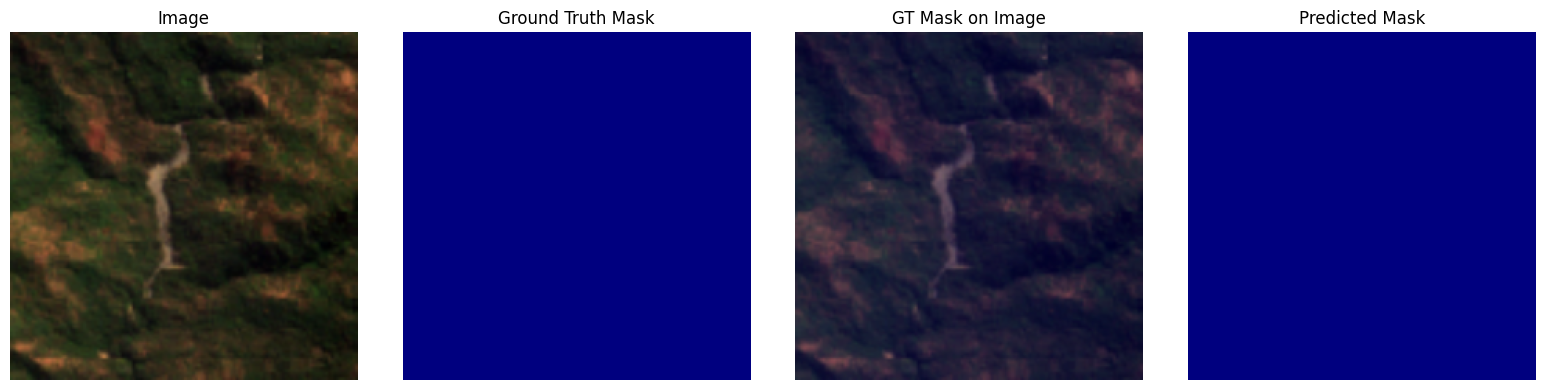

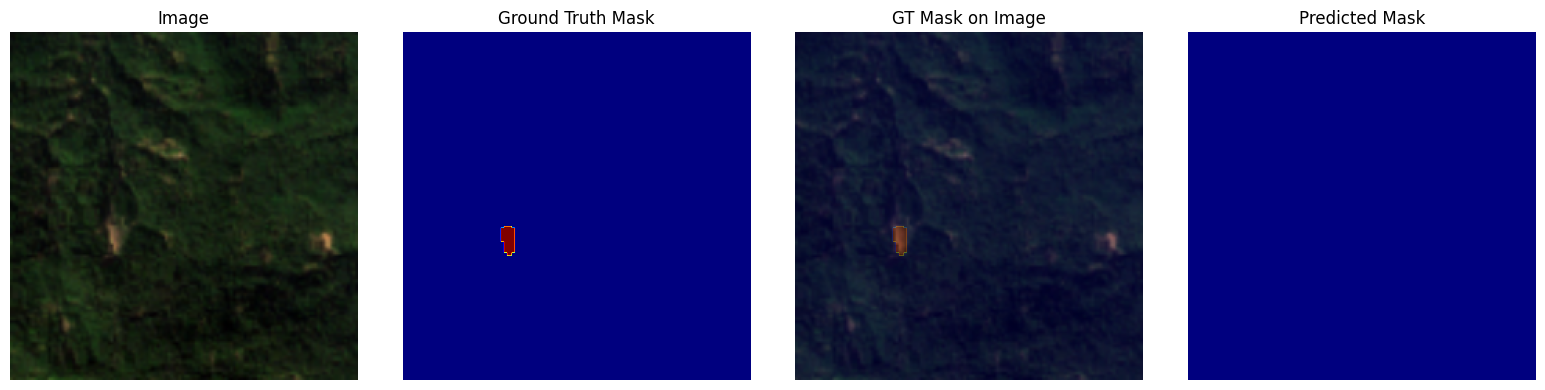

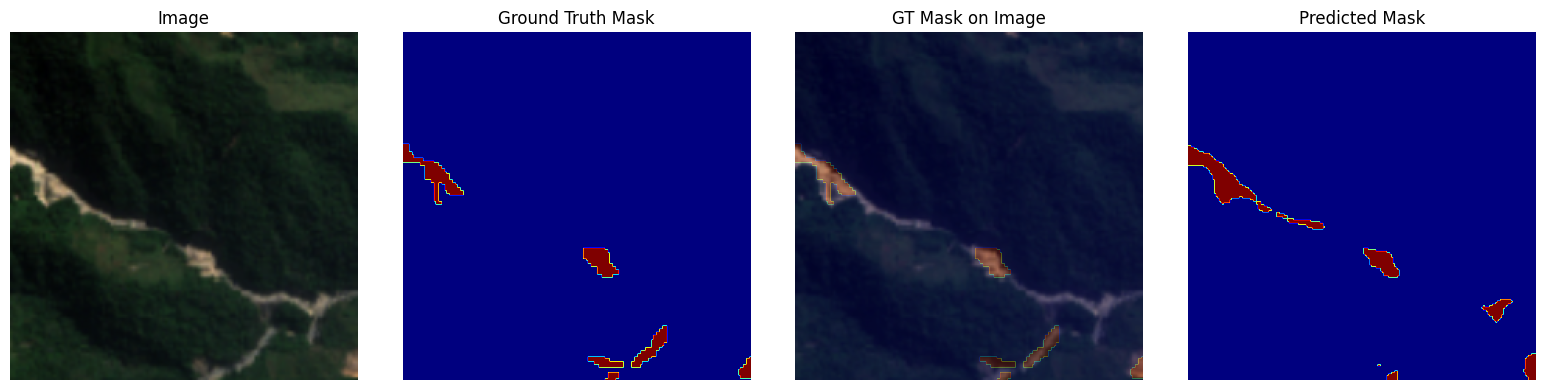

In [22]:
# now we can use the model for predictions and ploting!
datamodule.setup("test")
test_dataset = data_module.test_dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5,8):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)

In [4]:
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    lr=1.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipp

In [21]:
import torch
from pytorch_lightning import Trainer

trainer = Trainer(accelerator="auto")
predictions = trainer.predict(model, dataloaders=data_module.test_dataloader(),  ckpt_path="./landslide4sense.ckpt")

test_dataset = data_module.test_dataset
test_loader = data_module.test_dataloader()
batch = next(iter(test_loader))

with torch.no_grad():
    # `predictions` is a list of outputs for each batch. Concatenate to work with it.
    preds = torch.cat(predictions, dim=0)  # Assuming predictions are tensors

    # Get predictions as class indices
    preds = torch.argmax(preds, dim=1).cpu().numpy()

    # Plot specific samples (e.g., 5th to 7th)
    for i in range(5, 8):
        sample = {key: batch[key][i] for key in batch}  # Extract one sample
        sample["prediction"] = preds[i]  # Add prediction
        test_dataset.plot(sample)  # Visualize the sample

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `SemanticSegmentationTask`